# TF Agents

 A common pattern in reinforcement learning is to execute policy in an environment for a specified number of steps or episodes. This happens, for example during data collection and generating a video of the agent

## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf


import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
#import reverb

import tensorflow as tf


from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

## Hyperparameters

In [2]:
env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment


In [3]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## C51 Agent

In [4]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

Metal device set to: Apple M1 Pro


2022-06-25 13:56:41.265856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 13:56:41.266038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Metrics and evaluation

In [5]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [6]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)


20.300001

## Training

As in the DQN tutorial, setup the replay buffer and initial data collection with a random policy


In [7]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [8]:
def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

In [9]:
for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)


In [10]:
# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


2022-06-25 13:56:47.860075: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
next(iterator)

(Trajectory(
 {'action': <tf.Tensor: shape=(64, 3), dtype=int64, numpy=
 array([[1, 0, 1],
        [1, 0, 1],
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [1, 1, 0],
        [0, 1, 0],
        [0, 1, 1],
        [1, 1, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
        [1, 1, 1],
        [0, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 1],
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 1],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        [1, 0, 1],
        [0, 1, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 1, 1],
        [1, 0, 1],
        [1, 0, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 1, 1

## Training the agent

In [12]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [13]:
returns

[9.8]

In [14]:
for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


2022-06-25 13:56:48.914142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


step = 200: loss = 3.2276790142059326


step = 400: loss = 2.5604636669158936


step = 600: loss = 2.089113235473633


step = 800: loss = 1.6443257331848145


step = 1000: loss = 1.8396697044372559


step = 1000: Average Return = 77.40


KeyboardInterrupt: 

## Visualization

We can plot return vs global steps to see the performance of our agent. In cartpole-v1 environment gives a reward +1 for every time step the pole stays up, and since the maximum number of steps is 500. the maximum possible reward is 500

(-7.8699996948242195, 550.0)

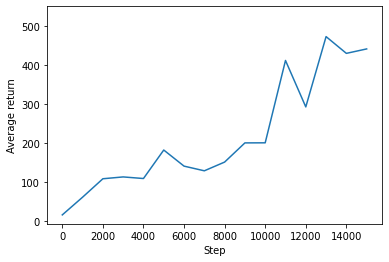

In [27]:
steps = range(0, num_iterations+1, eval_interval)
plt.plot(steps, returns)

plt.ylabel('Average return')
plt.xlabel('Step')
plt.ylim(top=550)

## Videos

In [28]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [34]:
import imageio

In [36]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

## Python drivers

The `PyDriver` class takes a python environment, a python policy and list of observers to update at each step. The main method `run()` steps the environment using actions from the policy until atleast of the following termination criteria is met:

1. max_steps
2. max_episodes

In [5]:
env = suite_gym.load('CartPole-v0')
policy = random_py_policy.RandomPyPolicy(time_step_spec=env.time_step_spec(), 
                                         action_spec=env.action_spec())

replay_buffer = []
metric = py_metrics.AverageReturnMetric()
observers = [replay_buffer.append, metric]

driver = py_driver.PyDriver(
    env, policy, observers, max_steps=20, max_episodes=1)

initial_time_step = env.reset()
final_time_step, _ = driver.run(initial_time_step)

print('Replay Buffer:')
for traj in replay_buffer:
  print(traj)

print('Average Return: ', metric.result())

Replay Buffer:
Trajectory(
{'action': array(0),
 'discount': array(1., dtype=float32),
 'next_step_type': array(1, dtype=int32),
 'observation': array([ 0.03138353,  0.00296163, -0.01096962, -0.04797763], dtype=float32),
 'policy_info': (),
 'reward': array(1., dtype=float32),
 'step_type': array(0, dtype=int32)})
Trajectory(
{'action': array(1),
 'discount': array(1., dtype=float32),
 'next_step_type': array(1, dtype=int32),
 'observation': array([ 0.03144277, -0.19200133, -0.01192917,  0.2412242 ], dtype=float32),
 'policy_info': (),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})
Trajectory(
{'action': array(1),
 'discount': array(1., dtype=float32),
 'next_step_type': array(1, dtype=int32),
 'observation': array([ 0.02760274,  0.00328898, -0.00710469, -0.05519751], dtype=float32),
 'policy_info': (),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})
Trajectory(
{'action': array(0),
 'discount': array(1., dtype=float32),
 'next_ste

In [4]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})